### **Import Package**

In [1]:
import zipfile
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
%matplotlib inline

from google.colab import files
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split, GridSearchCV

berikutnya lakukan instalasi untuk library kaggle

In [2]:
!pip install -q kaggle

lakukan upload file API Token kagglenya

In [3]:
uploaded = files.upload()

Saving kaggle.json to kaggle.json


berikutnya verifikasi kredensial API-nya

In [4]:
!chmod 600 /content/kaggle.json

In [5]:
! KAGGLE_CONFIG_DIR=/content/ kaggle datasets download -d arashnic/book-recommendation-dataset

 38% 9.00M/23.8M [00:00<00:00, 81.6MB/s]
100% 23.8M/23.8M [00:00<00:00, 123MB/s] 


### **Extract Data**

In [6]:
local_zip = '/content/book-recommendation-dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

### **Load dataset**

In [7]:
books = pd.read_csv('/content/Books.csv')
ratings = pd.read_csv('/content/Ratings.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


mengambil 5 data awal di books

In [8]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


mengambil 5 data awal di ratings

In [9]:
ratings.tail()

,User-ID,ISBN,Book-Rating
1149775,276704,1563526298,9
1149776,276706,0679447156,0
1149777,276709,0515107662,10
1149778,276721,0590442449,10
1149779,276723,05162443314,8


# **Data Understanding**

Untuk yang Books
- ISBN:  International Standard Book Number(bersifat unik).
- Book-Title: Judul Buku.
- Book-Author: Nama pengarang buku.
- Year-Of-Publication: Tahun penerbitan buku.
- Publisher: Pihak penerbit buku.
- Image-URL-S: URL yang menautkan ke gambar sampul berukuran kecil.
- Image-URL-M: URL yang menautkan ke gambar sampul berukuran normal.
- Image-URL-L: URL yang menautkan ke gambar sampul berukuran besar.

Untuk yang Ratings
- User-ID: Nomer unik user yang memberikan rating.
- ISBN: Kode pengidentifikasian buku yang bersifat unik.
- Book-Rating: Skor dari rating yang diberikan.= 

In [10]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271359 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


Terdapat 271360 entri dan seluruh tipe data dalam kolom books adalah object

In [11]:
print('Banyak data judul buku: ', len(books['Book-Title'].unique()))

Banyak data judul buku:  242135


In [12]:
title_list = books['Book-Title'].value_counts().keys()
jumlah = books['Book-Title'].value_counts()

jum_judul = pd.DataFrame({'Judul': title_list, 'Jumlah': jumlah}).reset_index(drop=True)
jum_judul

,Judul,Jumlah
0,Selected Poems,27
1,Little Women,24
2,Wuthering Heights,21
3,The Secret Garden,20
4,Dracula,20
...,...,...
242130,What Every Kid Should Know,1
242131,The Seventh Enemy (A Brady Coyne Mystery),1
242132,A Brace of Skeet,1
242133,"The Yellow Admiral (O'Brian, Patrick, Aubrey/M...",1


Dari data ini dapat kita lihat judul buku paling banyak adalah Selected Poems diikuti Little women dan Wuthering Heights.

In [13]:
print('Banyak data pengarang buku: ', len(books['Book-Author'].unique()))

Banyak data pengarang buku:  102024


In [14]:
author_list = books['Book-Author'].value_counts().keys()
jumlah = books['Book-Author'].value_counts()

jum_pengarang = pd.DataFrame({'Pengarang': author_list, 'Jumlah': jumlah}).reset_index(drop=True)
jum_pengarang

,Pengarang,Jumlah
0,Agatha Christie,632
1,William Shakespeare,567
2,Stephen King,524
3,Ann M. Martin,423
4,Carolyn Keene,373
...,...,...
102018,Linda Jackson,1
102019,Artiste C. Arthur,1
102020,Emily Pearl Kingsley,1
102021,Jean Cassels,1


Dari data ini dapat kita lihat penulis buku paling banyak adalah Agatha Cristie diikuti William Shakespeare dan Stephenn King.

In [15]:
print('Banyak data penerbit buku: ', len(books['Publisher'].unique()))

Banyak data penerbit buku:  16808


In [16]:
pub_list = books['Publisher'].value_counts().keys()
jumlah = books['Publisher'].value_counts()

jum_penerbit = pd.DataFrame({'Penerbit': pub_list, 'Jumlah': jumlah}).reset_index(drop=True)
jum_penerbit

,Penerbit,Jumlah
0,Harlequin,7535
1,Silhouette,4220
2,Pocket,3905
3,Ballantine Books,3783
4,Bantam Books,3646
...,...,...
16802,Hannover House,1
16803,"Amber Quill Press, LLC.",1
16804,Lunchbox Press,1
16805,Ugly Town,1


Dari data ini dapat kita lihat penulis buku paling banyak adalah Harlequin diikuti Siihoute dan Pocket.

In [17]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [18]:
list_rating = ratings['Book-Rating'].value_counts().keys()
jumlah = ratings['Book-Rating'].value_counts()

jum_rating = pd.DataFrame({'Ratings': list_rating, 'Jumlah': jumlah}).reset_index(drop=True)
jum_rating

,Ratings,Jumlah
0,0,716109
1,8,103736
2,10,78610
3,7,76457
4,9,67541
5,5,50974
6,6,36924
7,4,8904
8,3,5996
9,2,2759


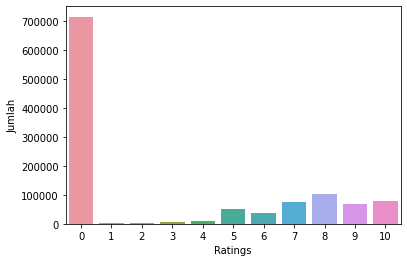

In [19]:
sns.barplot(data=jum_rating, x='Ratings', y='Jumlah')
plt.show()

Terlihat dari visualisasi bahwa range rating ada diantara nilai 0 sampai dengan 10 dan buku paling banyak adalah dengan rating 0 dari user yang sebanyak 716109 buku.

### **Memeriksa data kosong(missing value)**

In [20]:
books.isnull().sum()

ISBN                   0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64

In [21]:
ratings.isnull().sum()

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

Terlihat bahwa terdapat beberapa kolom yang memiliki nilai missing value pada data book sedangkan untuk ratings bersih tanpa missing value

In [22]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271359 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


In [23]:
kolom0 = ['Year-Of-Publication', 'Publisher', 'Image-URL-M', 'Image-URL-L']
books.drop(kolom0, axis=1, inplace=True)

Untuk melakukan Content Based Filtering kita tidak akan memanfaatkan beberapa kolom seperti yang sudah dimasukkan kedalam wadah yang diinisiasikan dengan nama kolom0

In [24]:
books.head()

,ISBN,Book-Title,Book-Author,Image-URL-S
0,0195153448,Classical Mythology,Mark P. O. Morford,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,http://images.amazon.com/images/P/0393045218.0...


Diatas merupakan tampilan kolom-kolom pada data buku kita yang sudah dilakukan drop beberapa value

### **Merging data buku dan rating**

In [25]:
ratings_baru = ratings.merge(books,on='ISBN')
ratings_baru = ratings_baru.groupby('Book-Title').sum()['Book-Rating'].reset_index()
ratings_baru.rename(columns={'Book-Rating':'Book-Ratings'}, inplace=True)

membuat sebuah variabel dengan nama ratings_baru yang kita merging dari rating buku dengan index ISBN, lalu di grouping berdasarkan judul buku.

In [26]:
buku_baru = pd.DataFrame({'Book-Title': books['Book-Title'].unique()})
buku_baru = pd.merge(buku_baru, ratings_baru, on='Book-Title', how='left')
buku_baru = buku_baru.merge(books, on='Book-Title').drop_duplicates('ISBN')

membuat sebuah variabel dengan nama buku_baru dengan memanfaatkan Dataframe pandas membuat key-nya serta memasukkan valuenya dari judul buku dengan unique, serta melakukan merging dengan index judul secara left. Berikutnya menghapus nilai duplikasi pada ISBN.

menghapus duplikasi data yang terdapat di list buku

In [27]:
buku_baru = buku_baru.drop_duplicates('Book-Title').reset_index(drop=True)
len(buku_baru['ISBN'].unique()), len(buku_baru['Book-Title'].unique())

(242135, 242135)

In [28]:
buku_baru.head()

,Book-Title,Book-Ratings,ISBN,Book-Author,Image-URL-S
0,Classical Mythology,7.0,0195153448,Mark P. O. Morford,http://images.amazon.com/images/P/0195153448.0...
1,Clara Callan,69.0,0002005018,Richard Bruce Wright,http://images.amazon.com/images/P/0002005018.0...
2,Decision in Normandy,15.0,0060973129,Carlo D'Este,http://images.amazon.com/images/P/0060973129.0...
3,Flu: The Story of the Great Influenza Pandemic...,47.0,0374157065,Gina Bari Kolata,http://images.amazon.com/images/P/0374157065.0...
4,The Mummies of Urumchi,0.0,0393045218,E. J. W. Barber,http://images.amazon.com/images/P/0393045218.0...


Hasil setelah dilakukan pembersihan 

In [29]:
buku_baru.isnull().sum()

Book-Title         0
Book-Ratings    1064
ISBN               0
Book-Author        1
Image-URL-S        0
dtype: int64

karena terdapat cukup banyak nilai missing value pada data book ratings kita akan menghapus nilai missing value tsb

In [30]:
buku_baru = buku_baru.dropna()
buku_baru.shape

(241070, 5)

In [31]:
buku_baru.isnull().sum()

Book-Title      0
Book-Ratings    0
ISBN            0
Book-Author     0
Image-URL-S     0
dtype: int64

Oke sudah aman dari nilai missing value

# **Content-Based Filtering**

Yang akan kita lakukan sampai tahap modelling nanti hanya buku dengan skor rating diatas 50 sampai dengan nilai 100

In [32]:
buku = buku_baru[buku_baru['Book-Ratings'].between(50, 100, inclusive = True)]
buku.drop(['ISBN', 'Book-Ratings'], axis=1, inplace=True)
buku

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Book-Title,Book-Author,Image-URL-S
1,Clara Callan,Richard Bruce Wright,http://images.amazon.com/images/P/0002005018.0...
21,New Vegetarian: Bold and Beautiful Recipes for...,Celia Brooks Brown,http://images.amazon.com/images/P/1841721522.0...
29,OUT OF THE SILENT PLANET,C.S. Lewis,http://images.amazon.com/images/P/0684823802.0...
54,All the King's Men,Robert Penn Warren,http://images.amazon.com/images/P/0156047624.0...
56,A Soldier of the Great War,Mark Helprin,http://images.amazon.com/images/P/0380715899.0...
...,...,...,...
144058,A Letter to Mrs. Roosevelt,C. COCO DE YOUNG,http://images.amazon.com/images/P/0385326335.0...
144734,Selected Poems (Penguin Popular Classics),Walt Whitman,http://images.amazon.com/images/P/0140622209.0...
160381,The Illustrated Alchemist: A Fable About Follo...,Paulo Coelho,http://images.amazon.com/images/P/006019250X.0...
165223,Ferne Ufer. Der 3. Band der groÃ?Â?en Highland...,Diana Gabaldon,http://images.amazon.com/images/P/3442350956.0...


# **Modelling**

Tfid Vectorizer

In [33]:
data = buku
data.sample(5)

,Book-Title,Book-Author,Image-URL-S
9587,Bears on Wheels (Bright &amp; Early Books),STAN BERENSTAIN,http://images.amazon.com/images/P/039480967X.0...
51806,Jolie Blon's Bounce : A Novel,James Lee Burke,http://images.amazon.com/images/P/0743204840.0...
5969,Lila: An Inquiry Into Morals,Robert M. Pirsig,http://images.amazon.com/images/P/0553299611.0...
5767,A Darker Dream,Amanda Ashley,http://images.amazon.com/images/P/050552208X.0...
2758,Domain,Steve Alten,http://images.amazon.com/images/P/0812579569.0...


In [34]:
tfid = TfidfVectorizer(token_pattern=r"(?u)\b\w\w+\b\s+\w+")
tfid.fit(data['Book-Author']) 

tfid.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['aaron naparstek',
 'aaron roy',
 'abbas milani',
 'abby bardi',
 'abigail thomas',
 'adam haslett',
 'adele faber',
 'adrian nicole',
 'adriana trigiana',
 'adriana trigiani',
 'agatha christie',
 'agota kristof',
 'ahmed rashid',
 'aimee bender',
 'akiyuki nosaka',
 'al franken',
 'alain de',
 'alan brown',
 'alan dean',
 'alan furst',
 'alan garner',
 'alan h',
 'alan lightman',
 'alan moore',
 'alan watts',
 'alastair reynolds',
 'albert  camus',
 'albert b',
 'albert camus',
 'alcoholics anonymous',
 'aldo leopold',
 'aldous huxley',
 'aleksandr solzhenitsyn',
 'alessandro baricco',
 'alessandro boffa',
 'alex garland',
 'alex kotlowitz',
 'alexander mccall',
 'alexander solzhenitsyn',
 'alexandra fuller',
 'alexandra lapierre',
 'alexandra ripley',
 'alexandra robbins',
 'alexandre dumas',
 'alfred bester',
 'ali smith',
 'alice blanchard',
 'alice borchardt',
 'alice gray',
 'alice hoffman',
 'alice joyce',
 'alice mcdermott',
 'alice munro',
 'alice walker',
 'alicia appleman'

Transformasi data kedalam bentuk matriks

In [35]:
tfidf_matrix = tfid.fit_transform(data['Book-Author']) 
tfidf_matrix.shape

(5188, 2475)

In [36]:
tfidf_matrix.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

Berikutnya kita akan menghitung Cosine Similarity

In [37]:
cosine_sim = cosine_similarity(tfidf_matrix) 
cosine_sim

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [38]:
cosine_sim_df = pd.DataFrame(cosine_sim, index=data['Book-Title'], columns=data['Book-Title'])
cosine_sim_df

Book-Title,Clara Callan,New Vegetarian: Bold and Beautiful Recipes for Every Occasion,OUT OF THE SILENT PLANET,All the King's Men,A Soldier of the Great War,The Dragons of Eden: Speculations on the Evolution of Human Intelligence,Tess of the D'Urbervilles (Wordsworth Classics),The Accidental Virgin,The Prince,Anil's Ghost,...,From Dawn to Decadence : 500 Years of Western Cultural Life 1500 to the Present,Four &amp; Twenty Blackbirds,Contacto,Cooking With Friends,Refuge: An Unnatural History of Family and Place,A Letter to Mrs. Roosevelt,Selected Poems (Penguin Popular Classics),The Illustrated Alchemist: A Fable About Following Your Dream,Ferne Ufer. Der 3. Band der groÃ?Â?en Highland- Saga.,The Ice House (TV Tie-In Edition)
Book-Title,,,,,,,,,,,,,,,,,,,,,
Clara Callan,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
New Vegetarian: Bold and Beautiful Recipes for Every Occasion,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
OUT OF THE SILENT PLANET,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
All the King's Men,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Soldier of the Great War,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A Letter to Mrs. Roosevelt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
Selected Poems (Penguin Popular Classics),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
The Illustrated Alchemist: A Fable About Following Your Dream,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## **Mendapatkan rekomendasi buku**


Mendapatkan rekomendasi buku berdasarkan pengarang yang sama dengan buku yang telah dibaca oleh user ini adalah pengaplikasian dari CBF yang mudahnya kita dapat membuat rekomendasi berdasarkan kemiripan yang disukai dari user berdasarkan masa lalu.

Akan dibuat fungsi book_recommendations yang diberikan parameter berupa name, similarity_data dengan metoode cosine, serta mengambil items, dan k.

In [39]:
def book_recommendations(book_name, similarity_data=cosine_sim_df, items=data, k=5):
  index = similarity_data[book_name].to_numpy().argpartition(range(-1, -(k+1), -1))[::-1]
  closest = similarity_data.columns[index[:k+1]]
  closest = closest.drop(book_name, errors='ignore')

  return pd.DataFrame(closest).merge(items).head(k)

Setelah kita selesai membuat fungsi kita akan melakukan pencarian bukunya dan mengambil judul yang pernah kita baca misalnya, lalu akan ditampilkan pengarang, judul dan url-nya.

In [40]:
buku_ref = 'Romeo and Juliet'
data[data['Book-Title'].eq(buku_ref)]

,Book-Title,Book-Author,Image-URL-S
19227,Romeo and Juliet,William Shakespeare,http://images.amazon.com/images/P/0671727680.0...


Berikutnya dengan fungsi tadi  kita akan mendapatkan 10 buku terkait dari buku yang mempunyai pengarang sama dengan yang pernah kita baca sebelumnya.

In [41]:
book_recommendations(buku_ref, k=10)

,Book-Title,Book-Author,Image-URL-S
0,The TEMPEST,William Shakespeare,http://images.amazon.com/images/P/0671722905.0...
1,Complete Works of William Shakespeare,William Shakespeare,http://images.amazon.com/images/P/0004704754.0...
2,ROMEO JULIET,William Shakespeare,http://images.amazon.com/images/P/0671509810.0...
3,King Lear (3rd Series),William Shakespeare,http://images.amazon.com/images/P/017443460X.0...
4,Merchant of Venice (New Folger Library Shakesp...,William Shakespeare,http://images.amazon.com/images/P/0671722778.0...
5,MIDSUMMER NIGHT'S DREAM,William Shakespeare,http://images.amazon.com/images/P/0671722794.0...
6,TAMING OF THE SHREW,William Shakespeare,http://images.amazon.com/images/P/0671722891.0...
7,Hamlet (Bantam Classics),William Shakespeare,http://images.amazon.com/images/P/0553212923.0...
8,AS YOU LIKE IT,William Shakespeare,http://images.amazon.com/images/P/0671531441.0...
9,A Midsummer Night's Dream (Signet Classic),William Shakespeare,http://images.amazon.com/images/P/0451526961.0...


- Jika dilihat dari hasil tersebut. Tingkat presisi dari sistem rekomendasi dengan teknik CBF yang kita buat dapat kita ketahui melalui seberapa banyak sistem dengan benar merekomendasikan buku berdasarkan pengarangnya. Dari 10 buku yang direkomendasikan semuanya memiliki pengarang yang sama dengan buku Romeo and Juliet. <br> Jadi dapat dikatakan tingkat presisi untuk hasil kita sangatlah baik yaitu 100%. Hal ini dikarenakan buku dengan Pengarang William Shakespeare yang terdapat pada data berjumlah 10. <br>Ini sebenarnya tidak lepas pula dengan banyaknya buku yang dikarang oleh William Shakespeare jadi data kita dapat mengenalinya dengan lebih baik.

# **Collaborative Filtering**

## **Data Preparation**


Melakukan penggabungan data<br>
Tidak seperti pada teknik Content-Based Filtering. Data yang digunakan di teknik Collaborative Filtering kali ini tidak memerlukan data Book-Author, dan Book-Ratings,. Sebab pada teknik ini hanya menggunakan rating sebagai acuan sistem rekomendasi.

In [42]:
df = ratings
df = df.merge(buku_baru, on='ISBN')
df.drop(['Book-Ratings', 'Book-Author'], axis=1, inplace=True)

Melakukan penyandian pada fitur User-ID dan Book-Title kedalam bentuk index

In [43]:
user_ids = df['User-ID'].unique().tolist()
user2encoded = {x: i for i, x in enumerate(user_ids)}
encoded2user = {i: x for i, x in enumerate(user_ids)}

In [44]:
book_isbns = df['ISBN'].unique().tolist()
book2encoded = {x: i for i, x in enumerate(book_isbns)}
encoded2book = {i: x for i, x in enumerate(book_isbns)}

Melakukan encode pada data book dan user

In [45]:
df['User-Encoded'] = df['User-ID'].map(user2encoded)
df['Book-Encoded'] = df['ISBN'].map(book2encoded)

Melakukan perhitungan jumlah user dan book setelah dilakukan encoding

In [46]:
num_users = len(user2encoded)
print(num_users)
 
num_books = len(encoded2book)
print(num_books)

df['Book-Rating'] = df['Book-Rating'].values.astype(np.float32)
 
min_rating = min(df['Book-Rating'])
max_rating = max(df['Book-Rating'])

print(f'Number of User: {num_users}, Number of Books: {num_books}, Min Rating: {min_rating}, Max Rating: {max_rating}')

83910
241060
Number of User: 83910, Number of Books: 241060, Min Rating: 0.0, Max Rating: 10.0


Mengambil 1 sampel berisikan User-ID, ISBN, Book-Rating, Book-Title, Image-URL-S, User-Encoded	serta Book-Encoded.

In [47]:
df.sample()

,User-ID,ISBN,Book-Rating,Book-Title,Image-URL-S,User-Encoded,Book-Encoded
543719,117210,0441007384,0.0,Titan A. E.: Akima's Story,http://images.amazon.com/images/P/0441007384.0...,31201,57460


## **Normalisasi data rating**

Melakukan transformasi data dan reshaping di nilai y nya

In [48]:
x = df[['User-Encoded', 'Book-Encoded']].values
y = df['Book-Rating'].values
y = y.reshape(-1, 1)

In [49]:
from sklearn.preprocessing import MinMaxScaler

Setlah memanggil MinMaxScaler kita  mentransformasikan fitur dengan scalling fitur ke rentang tertentu, dengan range default antara nol dan satu.

In [50]:
scaler = MinMaxScaler()
norm_y = scaler.fit_transform(y)
norm_y = norm_y.reshape(1, -1)[0]

## **Split dataset**

Melakukan train test split dengan proporsi train testnya sebesar 80% dan 20%. Lalu akan diberikan random state=123

In [51]:
x_train, x_val, y_train, y_val = train_test_split(x, norm_y, test_size=0.2, random_state=123)

In [52]:
def create_dataset(x, y, batch_size, buffer_size=None, shuffle=True):
  ds = tf.data.Dataset.from_tensor_slices((x, y))

  if shuffle:
    ds = ds.shuffle(buffer_size)

  ds = ds.batch(batch_size).cache().prefetch(tf.data.experimental.AUTOTUNE)

  return ds

In [53]:
batch_size = 128
buffer_size = len(x)

train_ds = create_dataset(x_train, y_train, batch_size, buffer_size)
val_ds = create_dataset(x_val, y_val, batch_size, shuffle=False)

## **Membangun Model**

Di sini, saya membuat class RecommenderNet dengan keras Model class seperti yang ada pada materi di kelas dicoding. Kode class RecommenderNet ini juga terinspirasi dari tutorial dalam situs Keras dengan beberapa adaptasi sesuai case yang kita pecahkan

In [54]:
class RecommenderNet(tf.keras.Model):
  def __init__(self, num_users, num_books, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)

    self.num_users = num_users
    self.num_books = num_books
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding(
        num_users,
        embedding_size,
        embeddings_initializer='he_normal',
        embeddings_regularizer=keras.regularizers.l2(1e-3),
    )
    self.user_bias = layers.Embedding(num_users, 1)
    self.books_embedding = layers.Embedding(
        num_books,
        embedding_size,
        embeddings_initializer='he_normal',
        embeddings_regularizer=keras.regularizers.l2(1e-3),
    )
    self.books_bias = layers.Embedding(num_books, 1)

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:, 0])
    user_bias = self.user_bias(inputs[:, 0])
    books_vector = self.books_embedding(inputs[:, 1])
    books_bias = self.books_bias(inputs[:, 1])

    dot_user_books = tf.tensordot(user_vector, books_vector, 2)

    x = dot_user_books + user_bias + books_bias

    return tf.nn.sigmoid(x)

In [55]:
embedding_size = 32

model = RecommenderNet(num_users, num_books, embedding_size)
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

Model kita ini menggunakan Binary Crossentropy untuk menghitung loss function, Adam (Adaptive Moment Estimation) sebagai optimizer, dan root mean squared error (RMSE) sebagai metrics evaluationnya. 

## **Train Model**

In [56]:
history = model.fit(
  train_ds,
  epochs = 20,
  validation_data = val_ds,
  verbose=1,
)

Epoch 1/20
5520/5520 [==============================] - 54s 9ms/step - loss: 0.6372 - root_mean_squared_error: 0.3851 - val_loss: 0.5684 - val_root_mean_squared_error: 0.3635
Epoch 2/20
5520/5520 [==============================] - 47s 9ms/step - loss: 0.5292 - root_mean_squared_error: 0.3484 - val_loss: 0.5227 - val_root_mean_squared_error: 0.3467
Epoch 3/20
5520/5520 [==============================] - 47s 9ms/step - loss: 0.4994 - root_mean_squared_error: 0.3326 - val_loss: 0.5109 - val_root_mean_squared_error: 0.3407
Epoch 4/20
5520/5520 [==============================] - 47s 9ms/step - loss: 0.4842 - root_mean_squared_error: 0.3239 - val_loss: 0.5055 - val_root_mean_squared_error: 0.3380
Epoch 5/20
5520/5520 [==============================] - 47s 9ms/step - loss: 0.4737 - root_mean_squared_error: 0.3178 - val_loss: 0.5029 - val_root_mean_squared_error: 0.3368
Epoch 6/20
5520/5520 [==============================] - 47s 8ms/step - loss: 0.4656 - root_mean_squared_error: 0.3129 - val_l

In [59]:
books_df = buku_baru.drop(['Book-Ratings', 'Book-Author'], axis=1)
df = pd.read_csv('/content/Ratings.csv')
 
user_id = df['User-ID'].sample(1).iloc[0]
buku_pilihan_user = df[df['User-ID'] == user_id]

book_no_choosen = books_df[~books_df['ISBN'].isin(buku_pilihan_user['ISBN'].values)]['ISBN']
book_no_choosen = list(
    set(book_no_choosen).intersection(set(book2encoded.keys())))
 
book_no_choosen = [[book2encoded.get(x)] for x in book_no_choosen]
user_encoder = user2encoded.get(user_id)
user_book_array = np.hstack(
    ([[user_encoder]] * len(book_no_choosen), book_no_choosen))

Melakukan flatten dan melihatkan rekomendasi untuk user

In [60]:
ratings = model.predict(user_book_array).flatten()
 
top_ratings = ratings.argsort()[-10:][::-1]
recommended_books_ids = [
    encoded2book.get(book_no_choosen[x][0]) for x in top_ratings
]
 
print(f'Showing recommendations for users: {user_id}')
print('===' * 10)
print('Books with high ratings from user')
print('===' * 10)
 
top_book_user = (
    buku_pilihan_user.sort_values(
        by = 'Book-Rating',
        ascending=False
    )
    .head(5)['ISBN'].values
)
 
books_df_rows = books_df[books_df['ISBN'].isin(top_book_user)]
for row in books_df_rows.itertuples():
    print(f'{row[1]} ({row[3]})')
 
print('----' * 10)
print('Top 10 book recommendation')
print('----' * 10)
 
recommended_book = books_df[books_df['ISBN'].isin(recommended_books_ids)]
for row in recommended_book.itertuples():
    print(f'{row[1]} ({row[3]})')

Showing recommendations for users: 76352
Books with high ratings from user
Here Be Dragons (http://images.amazon.com/images/P/0345382846.01.THUMBZZZ.jpg)
When Christ and His Saints Slept (http://images.amazon.com/images/P/0345396685.01.THUMBZZZ.jpg)
Dog Who Loved Too Much Tales Treatments (http://images.amazon.com/images/P/0340666269.01.THUMBZZZ.jpg)
Knight of Shadows (Amber Novels (Paperback)) (http://images.amazon.com/images/P/0380755017.01.THUMBZZZ.jpg)
Dog Talk: Training Your Dog Through a Canine Point of View (http://images.amazon.com/images/P/0312117787.01.THUMBZZZ.jpg)
----------------------------------------
Top 10 book recommendation
----------------------------------------
Elements of Style 3ED (http://images.amazon.com/images/P/0024182001.01.THUMBZZZ.jpg)
Fox in Socks (I Can Read It All by Myself Beginner Books) (http://images.amazon.com/images/P/0394800389.01.THUMBZZZ.jpg)
Death: The High Cost of Living (http://images.amazon.com/images/P/1563891336.01.THUMBZZZ.jpg)
The Lora

**Visualisasi dari metriknya**

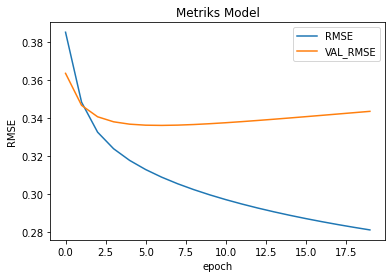

In [61]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('Metriks Model')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['RMSE', 'VAL_RMSE'])
plt.show()

Dari visualisasi model metriks tersebut dapat disimpulkan bahwa nilai konvergen metriks RMSE berada di sekitar angka 0.28 untuk training dan sekitar 0.34 untuk validasi  